In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from tabulate import tabulate
import statsmodels.api as sm

import qgrid
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



## __IE Calibration__

__28.05.2021__


Today, we tested 5 different concentrations of NH4NO3 standards with both AMS and SMPS for calibrating the IE values.

Ideally, we assumed the results from SMPS were reliable, and then transform the volume conc to mass conc with the density of NH4NO3 (1.725 ug/m3). Then, the fitted line of mass conc from AMS and SMPS were obtained, in which the slope will be used to correct the IE values for matching the results.   

For AMS,   $Nitrate\ (\mu g\ m^{-3}) = HRNO_{3}\cdot (M_{NO_3}+M_{NH_4})/M_{NO_3} = 1.299\cdot HRNO_{3}$    

For SMPS, $Nitrate\ (\mu g\ m^{-3}) = 1.725\ g\cdot cm^{-3}\cdot 10^{-9}\cdot Volume\ Conc\ (nm^{3}\cdot m^{-3}) $   

_Note: shape factor was not used this time_


### __1. Experimental Results__  


__1.1 General Overview__  

| Conc (ppm)   |   HROrg_AMS (ug/m3) |   NH4NO3_AMS (ug/m3) |   NH4NO3_SMPS (nm3/m3) |   NH4NO3_SMPS (ug/m3) |
|:-------------|--------------------:|---------------------:|-----------------------:|----------------------:|
| 20           |              61.778 |               80.232 |               1.45e+11 |               249.735 |
| 10           |              26.991 |               35.053 |               7.77e+10 |               134.093 |
| 5            |              12.918 |               16.777 |               4.68e+10 |                80.685 |
| 2            |               6.017 |                7.814 |               2.89e+10 |                49.916 |
| 1            |               3.623 |                4.706 |               2.06e+10 |                35.503 |
| water blank  |               1.518 |                1.972 |               1.41e+10 |                24.388 |    



__1.2 AMS HRNO3 time series & raw data__  

<img src="https://i.stack.imgur.com/taM5n.jpg" width = '900'>

In [27]:
df2 = pd.read_clipboard()

In [33]:
print(f'AMS Raw data')
def show_ams_data(conc):
    dt =df2[df2.Standard==conc]
    dt = dt.reset_index()
    dt = dt[dt.columns[1:-1]]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(dt)    
widgets.interact(show_ams_data, conc=["20 ppm", "10 ppm", "5 ppm",'2 ppm','1 ppm','water blank']);

AMS Raw data


interactive(children=(Dropdown(description='conc', options=('20 ppm', '10 ppm', '5 ppm', '2 ppm', '1 ppm', 'wa…

__1.3 SMPS raw data__  

In [39]:
df3 = pd.read_clipboard()

In [135]:
def show_smps_data(conc):
    dt =df3[df3.Standard==conc]
    dt = dt.reset_index()
    dt = dt[dt.columns[1:-1]]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(dt)    
widgets.interact(show_smps_data, conc=["20 ppm", "10 ppm", "5 ppm",'2 pm','1 pm','water blank']);

interactive(children=(Dropdown(description='conc', options=('20 ppm', '10 ppm', '5 ppm', '2 pm', '1 pm', 'wate…

### 2. __Linear fitting__

In [264]:
switch1,switch2 = 'on','non-zero'

In [272]:
def func_scatter_plot(func,x,y,popt,r_square):
    fig = plt.figure(figsize =(9,4))
    ax  = plt.subplot(121)
    plt.scatter(x,y, color ='#FF4D4D',s =120,zorder=5,lw = 1., edgecolor = 'k',)

    xx =  np.arange(0,100,2)
    yy =  func(xx, *popt)

    plt.plot(xx,yy,'-',color = 'steelblue',linewidth =1.5)

    plt.xlabel("AMS Conc ($\mu g\ m^{-3}$)",fontsize =14)
    plt.ylabel("SMPS Conc ($\mu g\ m^{-3}$)",fontsize =14)

    ax.grid(True)


    ax  = plt.subplot(122)

    plt.text(0.2,0.8,'y = a * x + b',fontsize=14)

    plt.text(0.2,0.6,'y = a * x + b',fontsize=14)

    plt.text(0.2,0.4,'y = a * x + b',fontsize=14)

    plt.text(0.2,0.2,'y = a * x + b',fontsize=14)

    fig.patch.set_visible(False)
    ax.axis('off')    
    
    plt.show()

In [274]:
def show_correlation_plot(Data,Format):
    if Data =='on':
        x = df['NH4NO3_AMS (ug/m3)'][:-1].values  - df['NH4NO3_AMS (ug/m3)'].iloc[-1]
        y = df['NH4NO3_SMPS (ug/m3)'][:-1].values - df['NH4NO3_AMS (ug/m3)'].iloc[-1]
    else:
        x = df['NH4NO3_AMS (ug/m3)'][:-1].values#  - df['NH4NO3_AMS (ug/m3)'].iloc[-1]
        y = df['NH4NO3_SMPS (ug/m3)'][:-1].values# - df['NH4NO3_AMS (ug/m3)'].iloc[-1]    

    # linear fitting  
    def get_r(f,x,y,popt):
        residuals = y- f(x, *popt)
        ss_res = np.sum(residuals**2)    
        ss_tot = np.sum((y-np.mean(y))**2)    
        r_squared = 1 - (ss_res / ss_tot)
        return (r_squared)

    if Format == 'intercept = 0':
        def func(x, a):
            return (a * x)
    if Format == "intercept ≠ 0":
        def func(x, a,b):
            return (a * x + b)
    popt, pcov = curve_fit(func, x, y)
    r_square = get_r(func,x,y, popt )   
    func_scatter_plot(func, x,y,popt,r_square)
    
    
widgets.interact(show_correlation_plot, Data=["with water blank substraction","without water blank substraction"],\
                Format=["intercept = 0","intercept ≠ 0"]);

interactive(children=(Dropdown(description='Data', options=('with water blank substraction', 'without water bl…

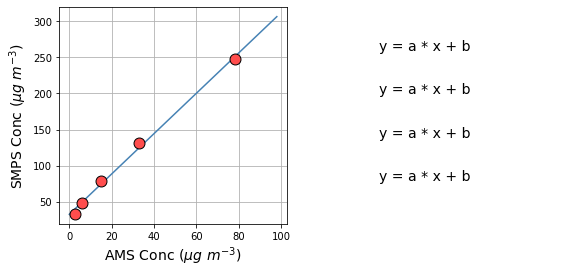

In [263]:
fig = plt.figure(figsize =(9,4))
ax  = plt.subplot(121)
plt.scatter(x,y, color ='#FF4D4D',s =120,zorder=5,lw = 1., edgecolor = 'k',)

xx =  np.arange(0,100,2)
yy =  func(xx, *popt)

plt.plot(xx,yy,'-',color = 'steelblue',linewidth =1.5)

plt.xlabel("AMS Conc ($\mu g\ m^{-3}$)",fontsize =14)
plt.ylabel("SMPS Conc ($\mu g\ m^{-3}$)",fontsize =14)

ax.grid(True)


ax  = plt.subplot(122)

plt.text(0.2,0.8,'y = a * x + b',fontsize=14)

plt.text(0.2,0.6,'y = a * x + b',fontsize=14)

plt.text(0.2,0.4,'y = a * x + b',fontsize=14)

plt.text(0.2,0.2,'y = a * x + b',fontsize=14)

fig.patch.set_visible(False)
ax.axis('off')

plt.show()

In [252]:
popt

array([ 2.79128989, 32.80476861])

['with water blank substraction', 'without water blank substraction']

In [165]:
import statsmodels.api as sm

data = pd.DataFrame(columns=['x','y'])
data['x'],data['y']=x,y

sm.OLS(formula = 'y ~ x + I(x**2)', data =data).fit()

TypeError: __init__() missing 1 required positional argument: 'endog'

In [181]:
olsres_ = sm.OLS(formula = 'y ~ x+I(x**0)', endog=y, exog=x).fit()

olsres_.params#,olsres_.rsquared

array([3.38215337])

In [184]:
np.random.seed(1)
X = sm.add_constant(np.arange(100))
y = np.dot(X, [1,2]) + np.random.normal(size=100)
result = sm.OLS(y, X).fit()
print(result.params)

[0.89516052 2.00334187]


In [186]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

In [187]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

In [191]:
np.dot(5,3)

15

In [192]:

x = df['NH4NO3_AMS (ug/m3)'][:-1].values  - df['NH4NO3_AMS (ug/m3)'].iloc[-1]
y = df['NH4NO3_SMPS (ug/m3)'][:-1].values - df['NH4NO3_AMS (ug/m3)'].iloc[-1]

In [154]:
import statsmodels.api as sm
# X_opt = np.array(X[:, [0, 1, 2, 3, 4, 5]], dtype=float)
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()

NameError: name 'X_opt' is not defined

In [145]:

    
    
    
    
degrees = [1]       # list of degrees of x to use
matrix = np.stack([x**d for d in degrees], axis=-1)   # stack them like columns
coefff = np.linalg.lstsq(matrix, y)[0]    # lstsq returns some additional info we ignore
print("Coefficients", coeff)
fit = np.dot(matrix, coeff)
print("Fitted curve/line", fit)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print (slope,intercept,r_value)

Coefficients [3.31830849]
Fitted curve/line [259.69082262 109.77296324  49.12755723  19.38555821   9.07225542]
2.7912898900278096 32.804768687134654 0.9978250107260845


<ipython-input-145-b21959639f21>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefff = np.linalg.lstsq(matrix, y)[0]    # lstsq returns some additional info we ignore


In [147]:
np.dot(matrix, coeff)

array([259.69082262, 109.77296324,  49.12755723,  19.38555821,
         9.07225542])

In [136]:
from scipy import stats
x = np.random.random(10)
y = np.random.random(10)


In [195]:
np.stack([x**d for d in [1]], axis=-1) 

array([[78.26 ],
       [33.081],
       [14.805],
       [ 5.842],
       [ 2.734]])

<ipython-input-196-43de1f6bfbd4>:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(x, y)


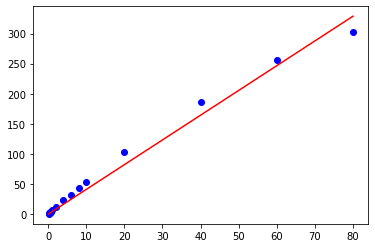

In [196]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 
              20.0, 40.0, 60.0, 80.0])

y = np.array([0.50505332505407008, 1.1207373784533172, 2.1981844719020001,
              3.1746209003398689, 4.2905482471260044, 6.2816226678076958,
              11.073788414382639, 23.248479770546009, 32.120462301367183, 
              44.036117671229206, 54.009003143831116, 102.7077685684846, 
              185.72880217806673, 256.12183145545811, 301.97120103079675])

# Our model is y = a * x, so things are quite simple, in this case...
# x needs to be a column vector instead of a 1D vector for this, however.
x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.plot(x, y, 'bo')
plt.plot(x, a*x, 'r-')
plt.show()

In [200]:
x

array([[ 0.1],
       [ 0.2],
       [ 0.4],
       [ 0.6],
       [ 0.8],
       [ 1. ],
       [ 2. ],
       [ 4. ],
       [ 6. ],
       [ 8. ],
       [10. ],
       [20. ],
       [40. ],
       [60. ],
       [80. ]])

Coefficients [3.31830849]
Fitted curve/line [266.23452696 116.31666758  55.67126158  25.92926256  15.61595977]


<ipython-input-107-ffe3c5a5dd75>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff = np.linalg.lstsq(matrix, y)[0]    # lstsq returns some additional info we ignore


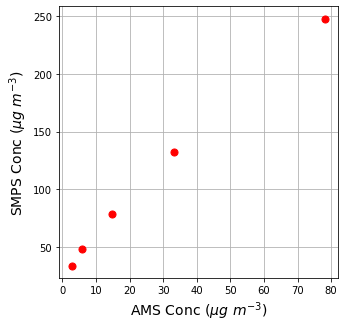

In [143]:
fig = plt.figure(figsize =(5,5))
ax  = plt.subplot(111)
cc = plt.scatter(x,y, color ='r',s =50,zorder=5)

# xx = np.arange(0,2000,1)
# yy = coeff*xx

# plt.plot(xx,yy,'b-')

plt.xlabel("AMS Conc ($\mu g\ m^{-3}$)",fontsize =14)
plt.ylabel("SMPS Conc ($\mu g\ m^{-3}$)",fontsize =14)


mplcursors.cursor(cc) # or just mplcursors.cursor()
# plt.text(666,255,"y = 0.562 x",fontsize =14)

ax.grid(True)
ax.set_facecolor("#FFFFFF")
plt.show()

In [71]:
url_

,name,url
0,peak width fitting,https://i.stack.imgur.com/rKIEC.jpg
1,peak shape,https://i.stack.imgur.com/EN2qk.jpg
2,m/z 30 peak fitting,https://i.stack.imgur.com/LVwfI.jpg
3,m/z 46 peak fitting,https://i.stack.imgur.com/KFqTi.jpg


In [58]:
url_ = pd.read_clipboard()

In [105]:
def show_image(Image):
    url = url_[url_['name']==Image]['url'].values[0]
    display(Disp.Image(requests.get(url).content,width='600'))
widgets.interact(show_image, Image=list(url_['name'].values));

interactive(children=(Dropdown(description='Image', options=('peak width fitting', 'peak shape', 'm/z 30 peak …